In [67]:
import pandas as pd

trainset_1 = pd.read_csv('EEG_mouse_data_1.csv')
trainset_2 = pd.read_csv('EEG_mouse_data_2.csv')
testset_1 = pd.read_csv('EEG_mouse_data_test.csv')

In [68]:
# visualisation des données par classe
def show_boxplots(df):
    fig, axs = plt.subplots(20, 5, figsize=(25, 120))
    axs = axs.flatten()

    for i, col in enumerate(df.columns[1:]):
        sns.boxplot(x='state', y=col, data=df, ax=axs[i])
    
    fig.suptitle('Boxplot of the amplitudes', fontsize=14)
    fig.tight_layout(rect=[0, 0.03, 1, 0.98])


In [69]:
# normlisation des features
from sklearn.preprocessing import StandardScaler
import pandas as pd

def normalize(df):
    headers = df.columns
    scaler = StandardScaler()
    
    numerical_columns = df.select_dtypes(include=['int', 'float']).columns
    df[numerical_columns] = scaler.fit_transform(df[numerical_columns])
    normalized_data = pd.DataFrame(df, columns=headers[:-1])

    return normalized_data

In [70]:
# Shuffling
import numpy as np

def shuffle_dataset_by_batch(data, batch_size):
    shuffled_data = data.sample(frac=1, replace=True).reset_index(drop=False)
    return shuffled_data


In [71]:
# extraction des colonnes
# envisager de faire la séléction des features ici
def extract_features(data, n):
    return data.iloc[:,:n+1]


In [72]:
from keras.layers import Input

def create_mlp_model(input_shape):
    inputs = Input(shape=input_shape)
    x = layers.Dense(25, activation='relu')(inputs)
    x = layers.Dense(25, activation='relu')(x)
    outputs = layers.Dense(1, activation='sigmoid')(x)
    model = keras.Model(inputs=inputs, outputs=outputs)
    
    model.compile(optimizer=keras.optimizers.SGD(learning_rate=0.01, momentum=0.99),
                  loss='mse', metrics=['accuracy'])
    return model


Epoch 1/10
423/423 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.5899 - loss: 0.4098 - val_accuracy: 0.6028 - val_loss: 0.3999
Epoch 2/10
423/423 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5992 - loss: 0.4008 - val_accuracy: 0.6028 - val_loss: 0.3999
Epoch 3/10
423/423 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.5992 - loss: 0.4008 - val_accuracy: 0.6028 - val_loss: 0.3999
Epoch 4/10
423/423 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.5992 - loss: 0.4008 - val_accuracy: 0.6028 - val_loss: 0.3999
Epoch 5/10
423/423 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.5992 - loss: 0.4008 - val_accuracy: 0.6028 - val_loss: 0.3999
Epoch 6/10
423/423 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.5992 - loss: 0.4008 - val_accuracy: 0.6028 - val_loss: 0.3999
Epoch 7/10
423/423 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.5992 - loss: 0.4008 - val_accuracy: 0.6028 - val_loss: 0.3999
Epoch 8/10
423/423 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.5992 - loss: 0.4008 - val_accuracy: 0.

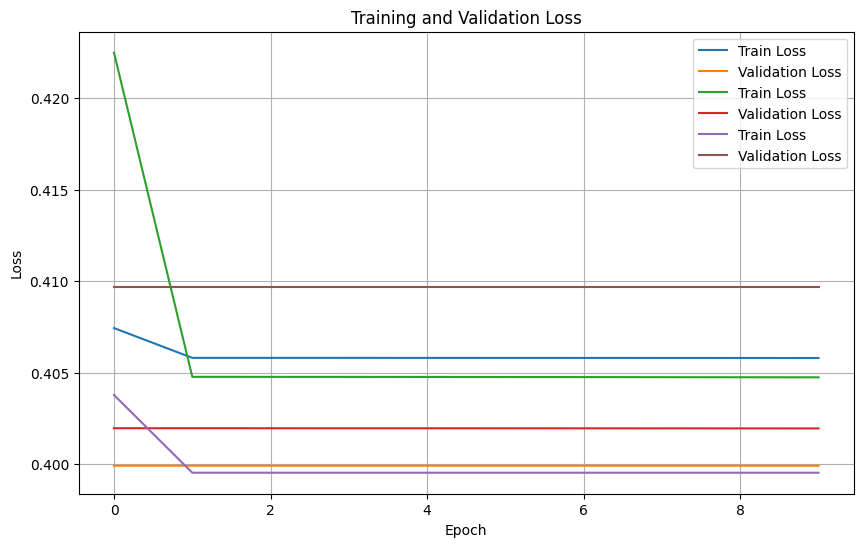

In [83]:
import seaborn as sns
import matplotlib.pyplot as plt
import keras
from keras import layers
from sklearn.model_selection import KFold
from sklearn.metrics import f1_score

# Programme principal de traitement du train set #1

normal_trainset_1 = extract_features(trainset_1, 25)
# normalisation
normal_trainset_1 = normalize(normal_trainset_1)
# suffling du dataset par batch de 32
shuffled_trainset_1 = shuffle_dataset_by_batch(normal_trainset_1, 10)

# initialisation du MLP
model = create_mlp_model(input_shape=(25,))

# splitting en 3 folds
keras.utils.set_random_seed(123)
kf = KFold(n_splits=3, shuffle=True)



y = shuffled_trainset_1['state'].map({'w': 1, 'r': 0, 'n': 0})
shuffled_trainset_1.drop(columns=['state'], inplace=True)

history_list = []
trained_mlp = []
for fold, (train_index, test_index) in enumerate(kf.split(shuffled_trainset_1)):
    
    model = create_mlp_model(input_shape=(25,))
    train_data_1 = shuffled_trainset_1.iloc[train_index]
    test_data_1 = shuffled_trainset_1.iloc[test_index]    
    
    history = model.fit(train_data_1.iloc[:, :], y.iloc[train_index], epochs=10, verbose=1, 
                        validation_data=(test_data_1.iloc[:, :], y.iloc[test_index]))
    
    loss, accuracy = model.evaluate(test_data_1.iloc[:, :], y.iloc[test_index])

    history_list.append(history)
    trained_mlp.append(model)


plt.figure(figsize=(10, 6))

for fold_history in history_list:
    plt.plot(fold_history.history['loss'], label='Train Loss')
    plt.plot(fold_history.history['val_loss'], label='Validation Loss')

# Ajout des titres et labels
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

